In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
from geopy.distance import geodesic

In [2]:
def load_bridge_data(csv_file_path):
    """Load bridge sensor data from CSV file"""
    df = pd.read_csv(csv_file_path)
    return df

In [3]:
def calculate_3d_distance(coord1, coord2):
    """Calculate 3D distance considering lat, lon, and altitude"""

    horizontal_dist = geodesic((coord1[0], coord1[1]), (coord2[0], coord2[1])).meters
    

    vertical_dist = abs(coord1[2] - coord2[2])
    
 
    distance_3d = np.sqrt(horizontal_dist**2 + vertical_dist**2)
    
    return distance_3d

In [4]:
def get_stiffness_value(src_type, tgt_type, distance_m):
    """
    Get stiffness value based on structural element types and distance
    pier: 1.2, girder: 1.0, pylon: 1.5, ground: 0.8
    """

    type_stiffness = {
        'pier': 1.2,
        'girder': 1.0, 
        'pylon': 1.5,
        'ground': 0.8
    }
    

    if ('pier' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.1  
    elif ('pylon' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.3  

    if src_type == tgt_type:
        base_stiffness = type_stiffness.get(src_type, 1.0)

        distance_factor = max(0.5, 1.0 - (distance_m / 500.0)) 
        return round(base_stiffness * distance_factor, 2)
    

    src_stiff = type_stiffness.get(src_type, 1.0)
    tgt_stiff = type_stiffness.get(tgt_type, 1.0)
    return round((src_stiff + tgt_stiff) / 2, 2)

In [5]:
def create_knn_edges(df, k=3):
    """Create edges using K-Nearest Neighbors algorithm with proper 3D distances"""
    # Extract coordinates (lat, lon, altitude)
    coords = df[['latitude', 'longitude', 'altitude_m']].values
    node_ids = df['node_id'].tolist()
    
    print(f"\nAnalyzing sensor positions:")
    girder_alts = df[df['type']=='girder']['altitude_m'].values
    pier_alts = df[df['type']=='pier']['altitude_m'].values
    ground_alts = df[df['type']=='ground']['altitude_m'].values
    
    print(f"Girder sensors altitude range: {min(girder_alts):.1f}m - {max(girder_alts):.1f}m")
    print(f"Pier sensors altitude range: {min(pier_alts):.1f}m - {max(pier_alts):.1f}m") 
    print(f"Ground sensors altitude: {ground_alts[0]:.1f}m")
    print(f"Typical girder-pier height difference: {np.mean(girder_alts) - np.mean(pier_alts):.1f}m")
    
    # Calculate all pairwise distances manually for better control
    n_nodes = len(df)
    distances_matrix = np.zeros((n_nodes, n_nodes))
    
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                dist = calculate_3d_distance(coords[i], coords[j])
                distances_matrix[i][j] = dist
    
    # For each node, find k nearest neighbors
    edge_info = []
    edges_set = set()
    
    for i in range(n_nodes):
        src_id = node_ids[i]
        src_type = df.iloc[i]['type']
        
        # Get sorted indices by distance (excluding self)
        distances_row = distances_matrix[i]
        # Remove self-distance (set to inf) and sort
        temp_distances = distances_row.copy()
        temp_distances[i] = np.inf
        sorted_indices = np.argsort(temp_distances)[:k]  # Get k nearest
        
        print(f"\nNode {src_id} ({src_type}) connects to:")
        for idx, j in enumerate(sorted_indices):
            tgt_id = node_ids[j]
            tgt_type = df.iloc[j]['type']
            distance = distances_matrix[i][j]
            print(f"  {idx+1}. {tgt_id} ({tgt_type}) - {distance:.1f}m")
        
        for j in sorted_indices:
            tgt_id = node_ids[j]
            tgt_type = df.iloc[j]['type']
            distance = distances_matrix[i][j]
            
            # Create sorted tuple to avoid duplicate edges
            edge = tuple(sorted((src_id, tgt_id)))
            if edge not in edges_set:
                edges_set.add(edge)
                
                # Determine edge type
                if src_type == tgt_type:
                    edge_type = src_type
                else:
                    edge_type = "support"  # All cross-type connections are support
                
                # Get custom stiffness value
                stiffness = get_stiffness_value(src_type, tgt_type, distance)
                
                edge_info.append({
                    'source': edge[0],
                    'target': edge[1],
                    'type': edge_type,
                    'stiffness': stiffness,
                    'distance_m': round(distance, 2),
                    'src_type': src_type,
                    'tgt_type': tgt_type
                })
    
    return edge_info

In [ ]:
def analyze_connections(df, edges):
    """Analyze the types of connections created"""
    print(f"\n=== Connection Analysis ===")
    

    connection_counts = {}
    for edge in edges:
        edge_type = edge['type']
        connection_counts[edge_type] = connection_counts.get(edge_type, 0) + 1
    
    print("Connection types:")
    for conn_type, count in sorted(connection_counts.items()):
        avg_stiffness = np.mean([e['stiffness'] for e in edges if e['type'] == conn_type])
        avg_distance = np.mean([e['distance_m'] for e in edges if e['type'] == conn_type])
        print(f"  {conn_type}: {count} edges (avg stiffness: {avg_stiffness:.2f}, avg distance: {avg_distance:.1f}m)")
    
   
    support_connections = [e for e in edges if e['type'] == 'support']
    print(f"\nImportant structural connections:")
    print(f"  Support connections (all cross-type): {len(support_connections)}")
    
    if support_connections:
        print("  Examples of support connections:")
        for conn in support_connections[:8]:  # Show first 8
            print(f"    {conn['source']} ({conn['src_type']}) ↔ {conn['target']} ({conn['tgt_type']}) - {conn['distance_m']:.1f}m")

In [7]:
def save_edges_csv(edges, filename='bridge_edges.csv'):
    """Save edges to CSV file"""
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['source', 'target', 'type', 'stiffness', 'distance_m', 'src_type', 'tgt_type'])
        for edge in edges:
            writer.writerow([edge['source'], edge['target'], edge['type'], 
                           edge['stiffness'], edge['distance_m'], edge['src_type'], edge['tgt_type']])
    print(f"Edges saved to {filename}")

In [8]:
def create_networkx_graph(df, edges):
    """Create NetworkX graph from nodes and edges"""
    G = nx.Graph()
    
    # Add nodes with attributes
    for _, row in df.iterrows():
        G.add_node(row['node_id'], 
                  type=row['type'],
                  pos=(row['longitude'], row['latitude']),
                  altitude=row['altitude_m'])
    
    # Add edges with attributes
    for edge in edges:
        G.add_edge(edge['source'], edge['target'],
                  type=edge['type'],
                  stiffness=edge['stiffness'],
                  distance_m=edge['distance_m'])
    
    return G

In [9]:
def visualize_bridge_network(G, df, k_value=3):
    """Create 2D and 3D visualizations of the bridge network"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
   
    pos = nx.get_node_attributes(G, 'pos')
    
    node_colors = []
    color_map = {'girder': 'yellow', 'pier': 'cyan', 'ground': 'green', 'pylon': 'red'}
    for node in G.nodes():
        node_colors.append(color_map[G.nodes[node]['type']])
    
 
    edge_colors = []
    edge_color_map = {
        'girder': 'blue',
        'pier': 'purple', 
        'ground': 'brown',
        'support': 'red',      
    }
    
    for edge in G.edges():
        edge_type = G.edges[edge]['type']
        edge_colors.append(edge_color_map.get(edge_type, 'gray'))
    

    edge_widths = [G.edges[edge]['stiffness'] * 1.5 for edge in G.edges()]
    
    nx.draw(G, pos, ax=ax1, with_labels=True, node_color=node_colors, 
            edge_color=edge_colors, node_size=400, font_size=9, font_weight='bold', width=edge_widths)
    ax1.set_title(f'Bridge Sensor Network (2D) - K={k_value}\nEdge width=stiffness, Red=support connections')
    
    
    node_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                  for color in color_map.values()]
    ax1.legend(node_legend, list(color_map.keys()), loc='upper left', title='Nodes')
    
    
    ax3d = fig.add_subplot(122, projection='3d')
    
   
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        z = G.nodes[node]['altitude']
        color = color_map[G.nodes[node]['type']]
        ax3d.scatter(x, y, z, c=color, s=150)
        ax3d.text(x, y, z + 1, str(node), fontsize=8)
    

    for edge in G.edges():
        x_coords = [G.nodes[edge[0]]['pos'][0], G.nodes[edge[1]]['pos'][0]]
        y_coords = [G.nodes[edge[0]]['pos'][1], G.nodes[edge[1]]['pos'][1]]
        z_coords = [G.nodes[edge[0]]['altitude'], G.nodes[edge[1]]['altitude']]
        

        edge_type = G.edges[edge]['type']
        edge_color = edge_color_map.get(edge_type, 'gray')
        stiffness = G.edges[edge]['stiffness']
            
        ax3d.plot(x_coords, y_coords, z_coords, color=edge_color, 
                 alpha=0.8, linewidth=stiffness * 1.5)
    
    ax3d.set_xlabel('Longitude')
    ax3d.set_ylabel('Latitude')
    ax3d.set_zlabel('Altitude (m)')
    ax3d.set_title(f'Bridge Sensor Network (3D) - K={k_value}\nRed=support connections')
    
  
    ax3d.set_box_aspect([4,2,1])  
    
    plt.tight_layout()
    plt.show()

In [10]:
def analyze_graph_properties(G):
    """Analyze and print graph properties"""
    print("=== Graph Network Analysis ===")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"Network density: {nx.density(G):.3f}")
    print(f"Is connected: {nx.is_connected(G)}")
    

    node_types = {}
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    print("\nNode type distribution:")
    for node_type, count in node_types.items():
        print(f"  {node_type}: {count}")
    

    edge_types = {}
    stiffness_stats = {}
    
    for edge in G.edges():
        edge_type = G.edges[edge]['type']
        stiffness = G.edges[edge]['stiffness']
        
        edge_types[edge_type] = edge_types.get(edge_type, 0) + 1
        
        if edge_type not in stiffness_stats:
            stiffness_stats[edge_type] = []
        stiffness_stats[edge_type].append(stiffness)
    
    print("\nEdge type distribution:")
    for edge_type, count in edge_types.items():
        avg_stiffness = np.mean(stiffness_stats[edge_type])
        print(f"  {edge_type}: {count} edges (avg stiffness: {avg_stiffness:.2f})")

=== Shin-Nakagawa Bridge Sensor Network Analysis ===
Loaded bridge sensor data:
   node_id    type   latitude   longitude  altitude_m
0       22  girder  36.357602  140.558276          10
1       26  girder  36.355846  140.556145          12
2       30  girder  36.355002  140.555271          10
3       32  girder  36.355692  140.556305          12
4       34  girder  36.354474  140.554707          10

Total sensors: 26
Sensor types: {'girder': 12, 'pier': 8, 'ground': 6}

=== Custom Stiffness Values ===
Pier edges: 1.2
Girder edges: 1.0
Pylon edges: 1.5
Ground edges: 0.8
Pier-Girder connections: 1.1 (IMPORTANT)
Pylon-Girder connections: 1.3

Creating edges with k=2

Analyzing sensor positions:
Girder sensors altitude range: 9.0m - 15.0m
Pier sensors altitude range: 6.0m - 9.0m
Ground sensors altitude: 0.0m
Typical girder-pier height difference: 3.2m

Node 22 (girder) connects to:
  1. 23 (pier) - 4.9m
  2. 24 (pier) - 15.2m

Node 26 (girder) connects to:
  1. 27 (pier) - 3.8m
  2. 53 (

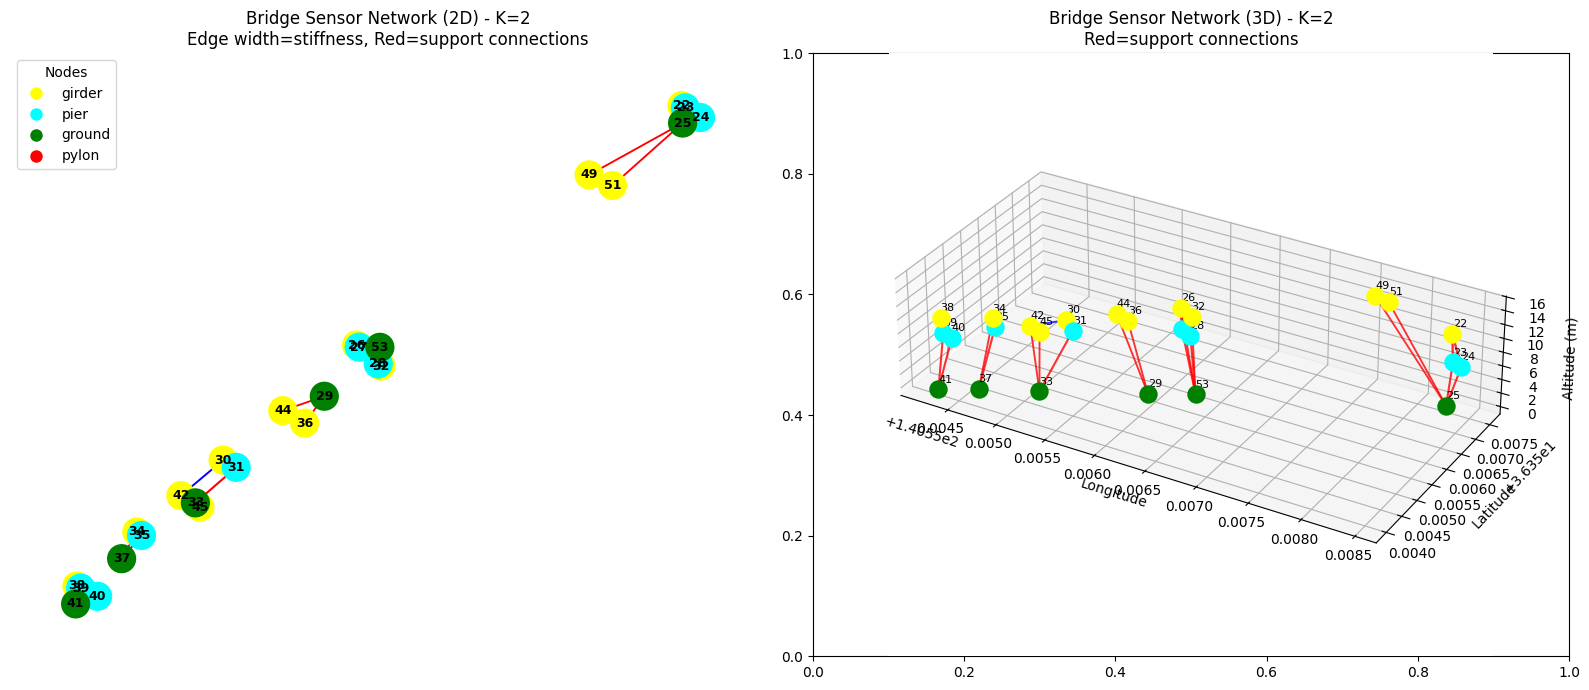


Creating edges with k=3

Analyzing sensor positions:
Girder sensors altitude range: 9.0m - 15.0m
Pier sensors altitude range: 6.0m - 9.0m
Ground sensors altitude: 0.0m
Typical girder-pier height difference: 3.2m

Node 22 (girder) connects to:
  1. 23 (pier) - 4.9m
  2. 24 (pier) - 15.2m
  3. 25 (ground) - 17.5m

Node 26 (girder) connects to:
  1. 27 (pier) - 3.8m
  2. 53 (ground) - 18.3m
  3. 28 (pier) - 20.1m

Node 30 (girder) connects to:
  1. 31 (pier) - 9.8m
  2. 42 (girder) - 38.1m
  3. 33 (ground) - 39.7m

Node 32 (girder) connects to:
  1. 28 (pier) - 3.8m
  2. 53 (ground) - 19.4m
  3. 27 (pier) - 20.2m

Node 34 (girder) connects to:
  1. 35 (pier) - 4.0m
  2. 37 (ground) - 25.5m
  3. 42 (girder) - 39.3m

Node 36 (girder) connects to:
  1. 44 (girder) - 16.4m
  2. 29 (ground) - 27.1m
  3. 31 (pier) - 54.0m

Node 38 (girder) connects to:
  1. 39 (pier) - 3.4m
  2. 40 (pier) - 14.9m
  3. 41 (ground) - 17.7m

Node 42 (girder) connects to:
  1. 33 (ground) - 13.7m
  2. 45 (girder) 

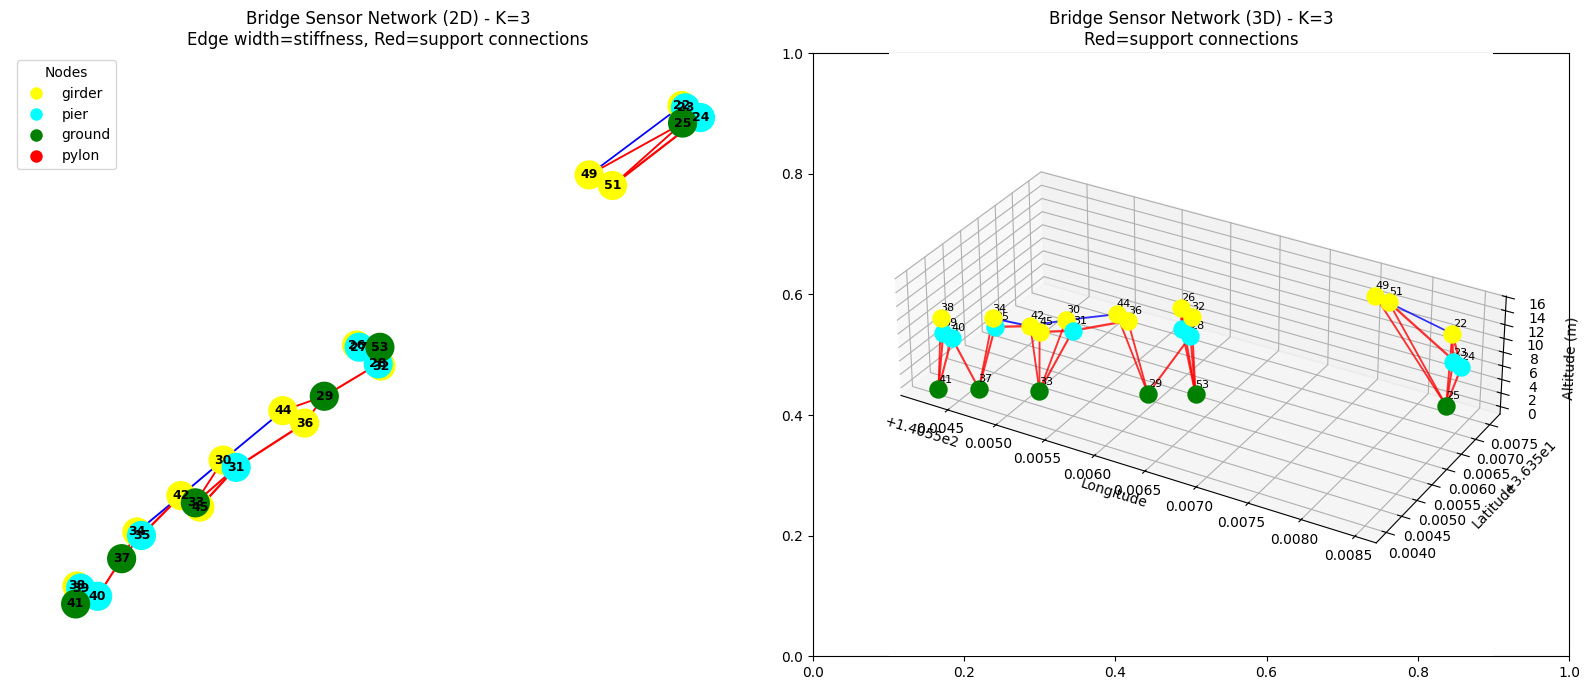


Creating edges with k=4

Analyzing sensor positions:
Girder sensors altitude range: 9.0m - 15.0m
Pier sensors altitude range: 6.0m - 9.0m
Ground sensors altitude: 0.0m
Typical girder-pier height difference: 3.2m

Node 22 (girder) connects to:
  1. 23 (pier) - 4.9m
  2. 24 (pier) - 15.2m
  3. 25 (ground) - 17.5m
  4. 51 (girder) - 77.0m

Node 26 (girder) connects to:
  1. 27 (pier) - 3.8m
  2. 53 (ground) - 18.3m
  3. 28 (pier) - 20.1m
  4. 32 (girder) - 22.3m

Node 30 (girder) connects to:
  1. 31 (pier) - 9.8m
  2. 42 (girder) - 38.1m
  3. 33 (ground) - 39.7m
  4. 45 (girder) - 40.6m

Node 32 (girder) connects to:
  1. 28 (pier) - 3.8m
  2. 53 (ground) - 19.4m
  3. 27 (pier) - 20.2m
  4. 26 (girder) - 22.3m

Node 34 (girder) connects to:
  1. 35 (pier) - 4.0m
  2. 37 (ground) - 25.5m
  3. 42 (girder) - 39.3m
  4. 45 (girder) - 42.2m

Node 36 (girder) connects to:
  1. 44 (girder) - 16.4m
  2. 29 (ground) - 27.1m
  3. 31 (pier) - 54.0m
  4. 30 (girder) - 56.6m

Node 38 (girder) connec

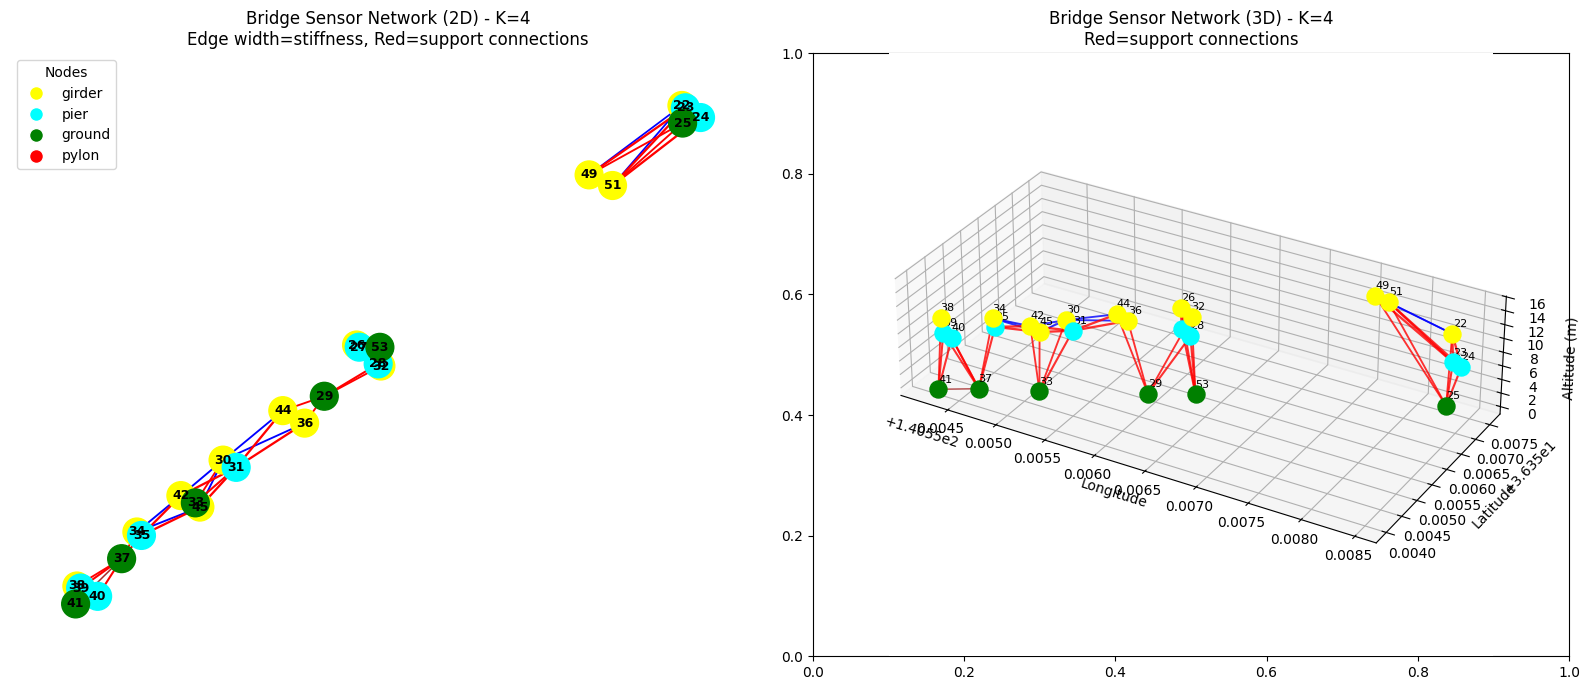


=== Edge Generation Complete ===
Files generated:
  - bridge_edges_k2_corrected.csv
  - bridge_edges_k3_corrected.csv
  - bridge_edges_k4_corrected.csv

Recommendation: Use k=3 for balanced connectivity
Key improvement: Now includes proper girder-pier connections!


In [ ]:
if __name__ == "__main__":
    # Updated CSV data with correct altitude values
    csv_data = """node_id,type,latitude,longitude,altitude_m
22,girder,36.35760246,140.5582758,10
26,girder,36.35584565,140.5561452,12
30,girder,36.35500155,140.555271,10
32,girder,36.35569158,140.5563046,12
34,girder,36.35447425,140.5547067,10
36,girder,36.35527276,140.5558051,11
38,girder,36.35407821,140.5543137,10
42,girder,36.35474124,140.5549947,9
44,girder,36.35536433,140.5556622,11
45,girder,36.3546569,140.5551193,9
49,girder,36.35709344,140.5576679,15
51,girder,36.35701549,140.5578214,15
23,pier,36.35758548,140.5582983,6
24,pier,36.35751402,140.5583976,6
27,pier,36.35582977,140.5561624,9
28,pier,36.35570737,140.5562867,9
31,pier,36.35494837,140.5553569,9
35,pier,36.35444892,140.5547367,9
39,pier,36.35406326,140.5543382,8
40,pier,36.35400257,140.5544497,8
25,ground,36.3574735,140.5582802,0
29,ground,36.35546989,140.555934,0
33,ground,36.35468793,140.5550896,0
37,ground,36.35427857,140.5546068,0
41,ground,36.35394661,140.5543055,0
53,ground,36.35582872,140.556298,0"""

  
    from io import StringIO
    df = pd.read_csv(StringIO(csv_data))
    
    print("=== Shin-Nakagawa Bridge Sensor Network Analysis ===")
    print("Loaded bridge sensor data:")
    print(df.head())
    print(f"\nTotal sensors: {len(df)}")
    print(f"Sensor types: {df['type'].value_counts().to_dict()}")
    
    print("\n=== Custom Stiffness Values ===")
    print("Pier edges: 1.2")
    print("Girder edges: 1.0")
    print("Pylon edges: 1.5")
    print("Ground edges: 0.8")
    print("Pier-Girder connections: 1.1 (IMPORTANT)")
    print("Pylon-Girder connections: 1.3")
    

    k_values = [2, 3, 4]
    
    for k in k_values:
        print(f"\n{'='*50}")
        print(f"Creating edges with k={k}")
        print(f"{'='*50}")
        
        edges = create_knn_edges(df, k=k)
        

        analyze_connections(df, edges)
        

        filename = f'bridge_edges_k{k}_corrected.csv'
        save_edges_csv(edges, filename)
        

        G = create_networkx_graph(df, edges)
        analyze_graph_properties(G)
        
   
        visualize_bridge_network(G, df, k_value=k)
    
    print(f"\n{'='*50}")
    print("=== Edge Generation Complete ===")
    print("Files generated:")
    for k in k_values:
        print(f"  - bridge_edges_k{k}_corrected.csv")
    print("\nRecommendation: Use k=3 for balanced connectivity")
    print("Key improvement: Now includes proper girder-pier connections!")